In [1]:
import sys
sys.path.append("/home/raulteixeira/repos/CSPZ/scripts/")
import NoiseSOM as ns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

In [2]:
plt.rc('font', family="serif")
plt.rc('font', size=12)
plt.rc('text', usetex=False)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #necessary to use \dfrac
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [3]:
path_data = "/project2/chihway/raulteixeira/data/"

In [4]:
pauscosmos = pd.read_parquet(path_data+"pauscosmos.parquet")
cosmos2020 = pd.read_parquet(path_data+"cosmos2020_classic.parquet")

#delve = pd.read_hdf(path_data+'DELVE_table1_000001.h5', key='data/table', mode='r')

specz = pd.read_table("/project2/chihway/delve_shear/BRPORTAL_E_6315_18670.csv", sep=',')

0 U
1 G
2 R


/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


3 I
4 Z
5 J
6 H
7 KS


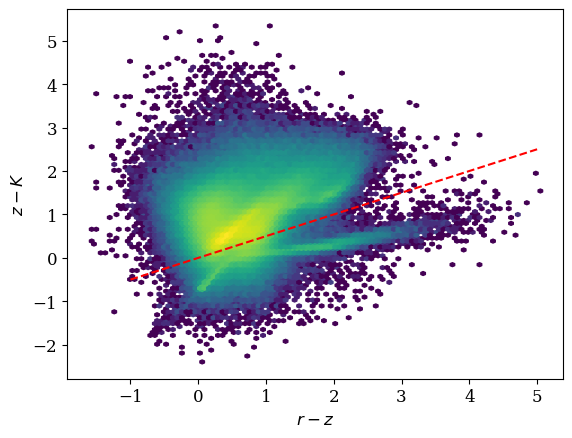

0 U
1 G
2 R
3 I
4 Z
5 J
6 H
7 KS
--- 20.62241005897522 seconds ---


In [5]:
start_time = time.time()

def flux2mag(flux):
    return -2.5 * np.log10(flux) + 30


df = pd.read_table(path_data+'deepfields.csv.gz', sep=',', header=0)


# Mask flagged regions
mask = df.MASK_FLAGS_NIR==0
mask &= df.MASK_FLAGS==0
mask &= df.FLAGS_NIR==0
mask &= df.FLAGS==0
mask &= df.FLAGSTR=="b'ok'"
mask &= df.FLAGSTR_NIR=="b'ok'"
df = df[mask]
df = df.drop(columns=[
    "MASK_FLAGS",
    "MASK_FLAGS_NIR",
    "FLAGS",
    "FLAGS_NIR",
    "FLAGSTR",
    "FLAGSTR_NIR",
])

deep_bands_ = ["U","G","R","I","Z","J","H","KS"]
# remove crazy colors, defined as two 
# consecutive colors (e.g u-g, g-r, r-i, etc) 
# that have a value smaler than -1
mags_d = np.zeros((len(df),len(deep_bands_)))
magerrs_d = np.zeros((len(df),len(deep_bands_)))

for i,band in enumerate(deep_bands_):
    print(i,band)
    mags_d[:,i] = flux2mag(df['BDF_FLUX_DERED_CALIB_%s'%band])

colors = np.zeros((len(df),len(deep_bands_)-1))
for i in range(len(deep_bands_)-1):
    colors[:,i] = mags_d[:,i] - mags_d[:,i+1]

normal_colors = np.mean(colors > -1, axis=1) == 1
normal_colors.sum()

df = df[normal_colors]

# mask faint objects, i < 25
df = df[flux2mag(df.BDF_FLUX_DERED_CALIB_I.values) < 25]

i = flux2mag(df.BDF_FLUX_DERED_CALIB_I.values)
r = flux2mag(df.BDF_FLUX_DERED_CALIB_R.values)
z = flux2mag(df.BDF_FLUX_DERED_CALIB_Z.values)
k = flux2mag(df.BDF_FLUX_DERED_CALIB_KS.values)


plt.hexbin((r-z), (z-k), gridsize=100, mincnt=1, bins='log')
_t = np.linspace(-1, 5, 100)
plt.plot(_t, 0.5*_t, color='r', ls='--')
plt.xlabel(r"$r-z$")
plt.ylabel(r"$z-K$")
plt.show()

# mask stars based on (z−K) > 0.5×(r −z) color cut

df = df[(z-k) > 0.5*(r-z)]

deep_data=df

deep_data.loc[:,"BDF_MAG_DERED_CALIB_I"]=flux2mag(deep_data.loc[:, 'BDF_FLUX_DERED_CALIB_I'])

def balrog_sigmoid(x, x0):
    """Sigmoid function
    Parameters
    ----------
    x : float or array-like
        Points at which to evaluate the function.
    x0 : float or array-like
        Location of transition.
    Returns
    -------
    sigmoid : scalar or array-like, same shape as input
    """
    return 1.0 - 1.0 / (1.0 + np.exp(-4.0 * (x - x0)))

def mock_balrog_sigmoid(
    deep_data, 
    sigmoid_x0,
    N,
    ref_mag_col = "BDF_MAG_DERED_CALIB_I"
):
    """
    Function for selecting deep field galaxies at a rate that follows a sigmoid function that smoothly transitions from 1 for bright objects, to a value of 0 for faint objects. 
    Parameters
    ----------
    deep_data : pandas dataframe
        Pandas dataframe containing the deep field data.
    sigmoid_x0 : float
        Magnitude value at which the sigmoid function transitions from 1 to 0.
    N : int
        Number of galaxies to be drawn.
    ref_mag_col : string
        Column name of the reference magnitude in deep_data
    Returns
    -------
    deep_balrog_selection : pandas dataframe
        Pandas dataframe containing a list of N deep field objects to be injected by Balrog.
    """
    np.random.seed()
    mag_ref = deep_data.loc[:, ref_mag_col].values
    weights = balrog_sigmoid(mag_ref, sigmoid_x0)
    weights/=sum(weights)
    selected_objects = np.random.choice(len(deep_data), N, p=weights, replace=True)
    
    deep_balrog_selection = deep_data.iloc[selected_objects]
    return deep_balrog_selection
                          
    
# New Pandas Dataframe with only detected galaxies
# A value of 23.0 returns something similar to Balrog Y3
# A value of 23.5 maybe is similar to the WL sample in Y6.
# A value of 21.5 is maybe optimal for LSS samples in Y6.
#deep_balrog_mocked = mock_balrog_sigmoid(deep_data, 23.0, nTrain)

nTrain = int(5e5)
deep_balrog_mocked = mock_balrog_sigmoid(deep_data, 23.0, nTrain)

bands = ['U','G','R','I','Z','J','H','KS']
fluxes_d = np.zeros((len(deep_balrog_mocked),len(bands)))
fluxerrs_d = np.zeros((len(deep_balrog_mocked),len(bands)))

for i,band in enumerate(bands):
    print(i,band)
    fluxes_d[:,i] = deep_balrog_mocked['BDF_FLUX_DERED_CALIB_%s'%band]
    fluxerrs_d[:,i] = deep_balrog_mocked['BDF_FLUX_ERR_DERED_CALIB_%s'%band]

# Train the SOM with this set (takes a few hours on laptop!)
#len(fluxes_d)

# Scramble the order of the catalog for purposes of training
#indices = np.random.choice(nTrain, size=nTrain, replace=False)
indices = np.random.choice(nTrain, size=int(5e4), replace=False)
hh = ns.hFunc(nTrain, sigma=(30,1))
metric = ns.AsinhMetric(lnScaleSigma=0.4, lnScaleStep=0.03)
print("--- %s seconds ---" % (time.time() - start_time))

In [7]:
fluxes_d.shape

(500000, 8)

In [11]:
# Match spectra to DELVE catalog
spec_cd = SkyCoord(ra=specz['RA'].values*u.degree, dec=specz['DEC'].values*u.degree)
deep_cd = SkyCoord(ra=deep_data['RA'].values*u.deg, dec=deep_data['DEC'].values*u.deg)
idx, d2d, d3d = deep_cd.match_to_catalog_sky(spec_cd)
good_matches = d2d < 1.0*u.arcsec

print(len(np.unique(idx[good_matches])), np.count_nonzero(good_matches))

# Add spectra to DELVE catalog
deep_data['zspec'] = np.nan
deep_data.loc[good_matches, 'zspec'] = specz.iloc[idx[good_matches], specz.columns.get_loc('Z')].values

38079 38086


In [12]:
# Match spectra to DELVE catalog
spec_cd = SkyCoord(ra=pauscosmos['ra'].values*u.degree, dec=pauscosmos['dec'].values*u.degree)
deep_cd = SkyCoord(ra=deep_data['RA'].values*u.deg, dec=deep_data['DEC'].values*u.deg)
idx, d2d, d3d = deep_cd.match_to_catalog_sky(spec_cd)
good_matches = d2d < 1.0*u.arcsec

print(len(np.unique(idx[good_matches])), np.count_nonzero(good_matches))

# Add spectra to DELVE catalog
deep_data['paus_z'] = np.nan
deep_data.loc[good_matches, 'paus_z'] = pauscosmos.iloc[idx[good_matches], pauscosmos.columns.get_loc('photoz')].values

28962 28962


In [13]:
# Match spectra to DELVE catalog
spec_cd = SkyCoord(ra=cosmos2020['alpha_j2000'].values*u.degree, dec=cosmos2020['delta_j2000'].values*u.degree)
deep_cd = SkyCoord(ra=deep_data['RA'].values*u.deg, dec=deep_data['DEC'].values*u.deg)
idx, d2d, d3d = deep_cd.match_to_catalog_sky(spec_cd)
good_matches = d2d < 1.0*u.arcsec

print(len(np.unique(idx[good_matches])), np.count_nonzero(good_matches))

# Add spectra to DELVE catalog
deep_data['cosmos_z'] = np.nan
deep_data.loc[good_matches, 'cosmos_z'] = cosmos2020.iloc[idx[good_matches], cosmos2020.columns.get_loc('ez_z_phot')].values

139933 139939


In [14]:
deep_data['Z']=np.nan
deep_data['good_Z']=np.nan

deep_data['Z']=deep_data['zspec']
deep_data['Z'][np.isnan(deep_data['Z'])]=deep_data['paus_z'][np.isnan(deep_data['Z'])]
deep_data['Z'][np.isnan(deep_data['Z'])]=deep_data['cosmos_z'][np.isnan(deep_data['Z'])]

deep_data['good_Z']=deep_data['zspec']
deep_data['good_Z'][np.isnan(deep_data['good_Z'])]=deep_data['paus_z'][np.isnan(deep_data['good_Z'])]

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if

In [16]:

# %time
# som = ns.NoiseSOM(metric, fluxes_d[indices,:], fluxerrs_d[indices,:], \
#     learning=hh, \
#     shape=(48,48), \
#     wrap=False,logF=True, \
#     initialize='sample', \
#     minError=0.02)

# path_cats='/project2/chihway/raulteixeira/data/'
# # And save the resultant weight matrix
# np.save("%s/som_deep_48_48.npy"%path_cats,som.weights)


In [17]:
# nTrain=5e4
# path_cats='/project2/chihway/raulteixeira/data/'
# som_weights_5e4 = np.load("%s/som_deep_48_48.npy"%path_cats,allow_pickle=True)
# hh = ns.hFunc(nTrain,sigma=(30,1))
# metric = ns.AsinhMetric(lnScaleSigma=0.4,lnScaleStep=0.03)
# som = ns.NoiseSOM(metric,None,None, \
#     learning=hh, \
#     shape=(48,48), \
#     wrap=False,logF=True, \
#     initialize=som_weights_5e4, \
#     minError=0.02)

In [18]:
nTrain=5e5
path_cats='/project2/chihway/raulteixeira/data/'
som_weights_5e5 = np.load("%s/som_deep_48_48_5e5.npy"%path_cats,allow_pickle=True)
hh = ns.hFunc(nTrain,sigma=(30,1))
metric = ns.AsinhMetric(lnScaleSigma=0.4,lnScaleStep=0.03)
som = ns.NoiseSOM(metric,None,None, \
    learning=hh, \
    shape=(48,48), \
    wrap=False,logF=True, \
    initialize=som_weights_5e5, \
    minError=0.02)

In [19]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# fig, axes = plt.subplots(4, 2, figsize=(12, 24))

# for i in range(4):
#     for j in range(2):
#         im = axes[i,j].imshow(30-2.5*np.log(som_weights_5e4).reshape(48,48,8)[:,:,2*i+j])
#         divider = make_axes_locatable(axes[i,j])
#         cax = divider.append_axes('right', size='5%', pad=0.05)
#         fig.colorbar(im, cax=cax, orientation='vertical')
# plt.show()

In [20]:
a = np.load('/project2/chihway/raulteixeira/data/som_deep_48x48_nooutliers_assign.npz')
deep_data['cells']=a['cells']

In [30]:
deep_data.columns

Index(['ID', 'RA', 'DEC', 'KNN_CLASS', 'BDF_FLUX_DERED_CALIB_U',
       'BDF_FLUX_DERED_CALIB_G', 'BDF_FLUX_DERED_CALIB_R',
       'BDF_FLUX_DERED_CALIB_I', 'BDF_FLUX_DERED_CALIB_Z',
       'BDF_FLUX_DERED_CALIB_J', 'BDF_FLUX_DERED_CALIB_H',
       'BDF_FLUX_DERED_CALIB_KS', 'BDF_FLUX_ERR_DERED_CALIB_U',
       'BDF_FLUX_ERR_DERED_CALIB_G', 'BDF_FLUX_ERR_DERED_CALIB_R',
       'BDF_FLUX_ERR_DERED_CALIB_I', 'BDF_FLUX_ERR_DERED_CALIB_Z',
       'BDF_FLUX_ERR_DERED_CALIB_J', 'BDF_FLUX_ERR_DERED_CALIB_H',
       'BDF_FLUX_ERR_DERED_CALIB_KS', 'BDF_MAG_DERED_CALIB_I', 'zspec',
       'paus_z', 'cosmos_z', 'Z', 'good_Z', 'cells', 'i', 'u-i', 'g-i', 'r-i',
       'z-i', 'j-i', 'h-i', 'ks-i', 'u-g', 'g-r', 'i-z', 'z-J', 'J-H', 'H-KS'],
      dtype='object')

In [22]:
bands_no_i = bands[:3]+bands[4:]

In [24]:
good_bands = [band.lower() for band in bands[:5]]+bands[5:]

In [26]:
bdfroot = 'BDF_FLUX_DERED_CALIB_'
color_labels = []
for i in range(7):
    label = good_bands[i]+'-'+good_bands[i+1]
    deep_data[label] = flux2mag(deep_data[bdfroot+bands[i]])-flux2mag(deep_data[bdfroot+bands[i+1]])
    color_labels.append(label)
    
feat_labels = ['i']+color_labels

In [27]:
feature_labels = ['i']
feature_labels+=[f'{band}-i' for band in [band.lower() for band in bands]]
del feature_labels[4]
print(feature_labels)

bdfroot = 'BDF_FLUX_DERED_CALIB_'

deep_data[feature_labels[0]] = flux2mag(deep_data[bdfroot+bands[3]])
for band, featlab in zip(bands_no_i, feature_labels[1:]):
    deep_data[featlab] = flux2mag(deep_data[bdfroot+band])-deep_data[feature_labels[0]]

['i', 'u-i', 'g-i', 'r-i', 'z-i', 'j-i', 'h-i', 'ks-i']


In [ ]:
#chi2[:nz,:nt]=fgg-power(fgt[:nz,:nt],2)/ftt[:nz,:nt]

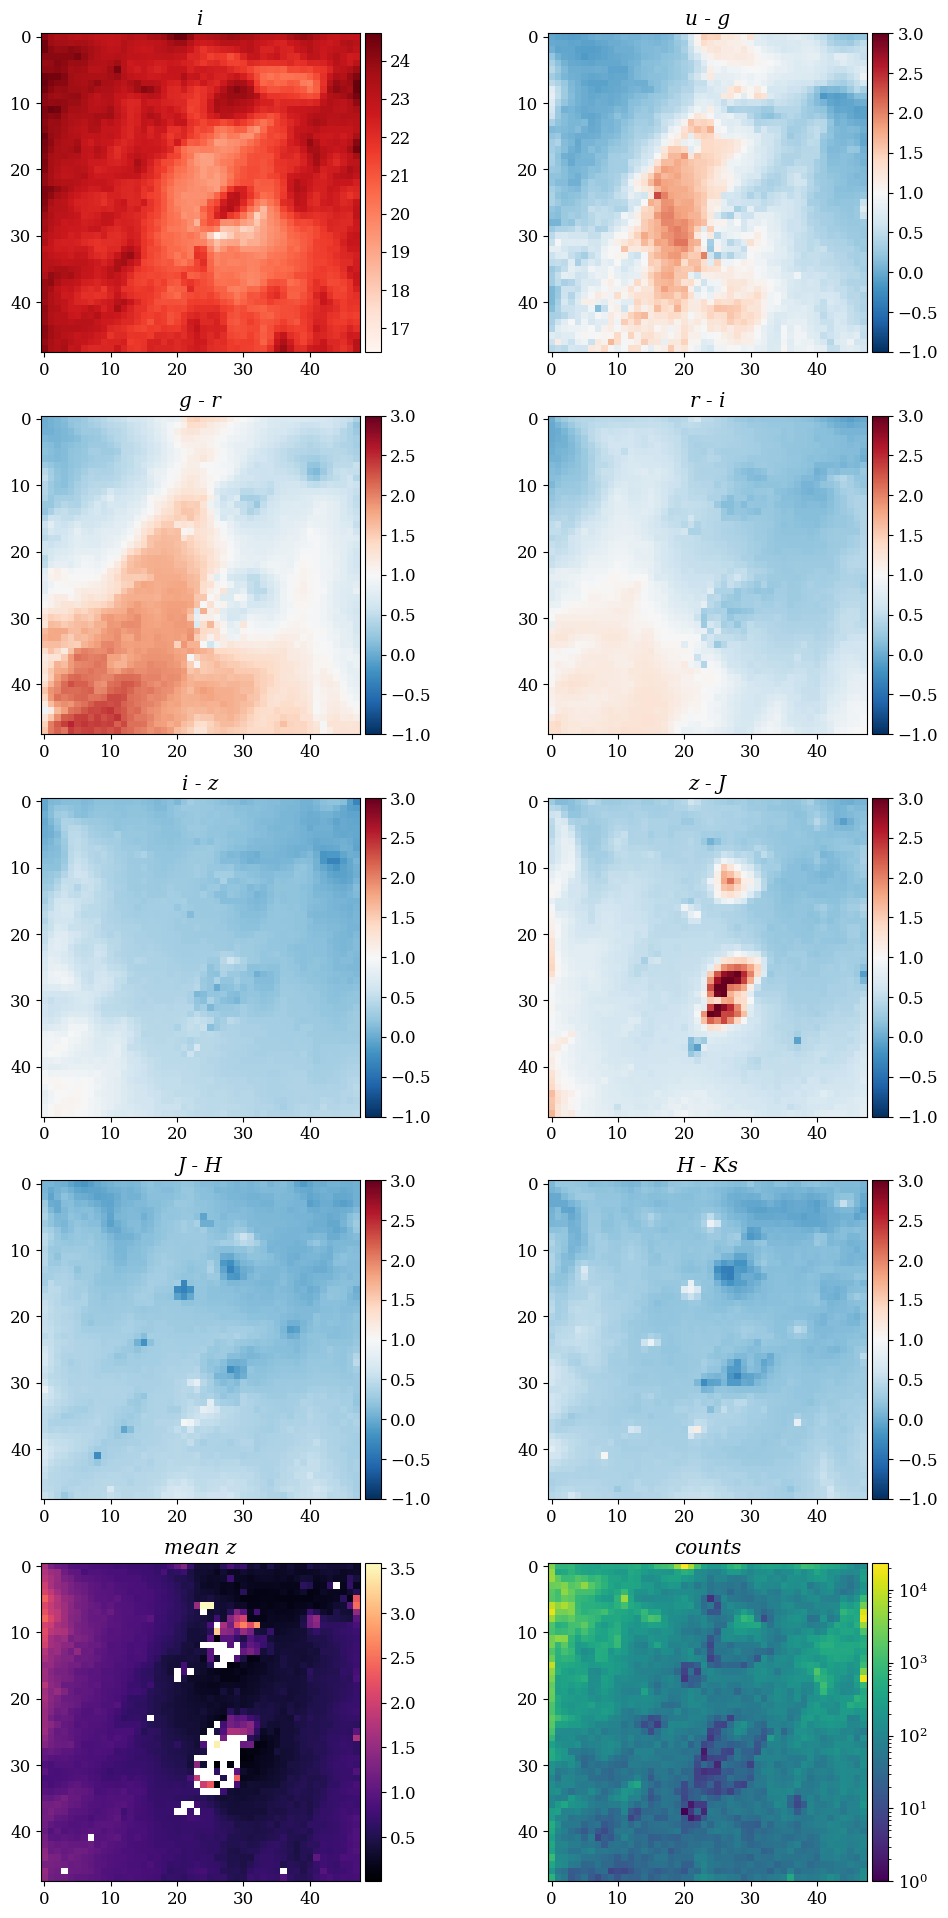

In [31]:
bts = [feat.split('-') for feat in feat_labels] #bt stands for broken title
titles = bts[0]+[bt[0]+' - '+bt[1] for bt in bts if len(bt)!=1]
titles[-1]='H - Ks'
fig, axes = plt.subplots(5, 2, figsize=(12, 24))
n=48
for i in range(5):
    for j in range(2):
        fun = 'mean'
        vmin,vmax=None,None
        norm=None
        if i==0 and j==0: cmap = 'Reds'
        elif i==4 and j == 0: cmap = 'magma'
        elif i==4 and j == 1: 
            cmap = 'viridis'
            fun = 'len'
            norm = LogNorm()
        else: 
            cmap = 'RdBu_r'
            vmin,vmax=-1,3
        
        feat = (feat_labels+['good_Z', 'i'])[2*i+j]
        title = (titles+['mean z', 'counts'])[2*i+j]
        square = deep_data[[feat, 'cells']].groupby('cells').agg(['mean', 'median', 'std', len])
        im = square[(feat, fun)].values.reshape(n,n)
        image = axes[i,j].imshow(im, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
        divider = make_axes_locatable(axes[i,j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(image, cax=cax, orientation='vertical')
        axes[i,j].set_title(f'{title}',style='italic')
plt.show()

In [37]:
squares

{'i':             mean     median       std   len
 cells                                      
 0      24.173265  24.293033  0.507978  3411
 1      23.679801  23.880063  0.672025   761
 2      23.443104  23.596013  0.609352   743
 3      23.471677  23.615899  0.589306   777
 4      23.273244  23.387943  0.606849   436
 ...          ...        ...       ...   ...
 2299   22.361140  22.411067  0.626101   108
 2300   22.095132  22.205949  0.751072    53
 2301   21.791942  21.771788  0.700877    69
 2302   22.119425  22.190079  0.690351    86
 2303   23.060917  23.284099  0.707998   154
 
 [2304 rows x 4 columns],
 'u-g':            mean    median       std   len
 cells                                    
 0     -0.038196 -0.094309  0.325530  3411
 1     -0.066063 -0.096739  0.252681   761
 2     -0.083180 -0.104460  0.248261   743
 3     -0.095846 -0.094665  0.117255   777
 4     -0.078976 -0.075740  0.107566   436
 ...         ...       ...       ...   ...
 2299   0.544795  0.550303  0.3

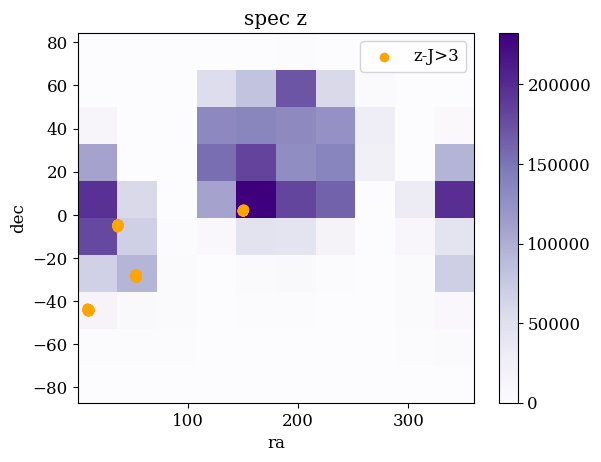

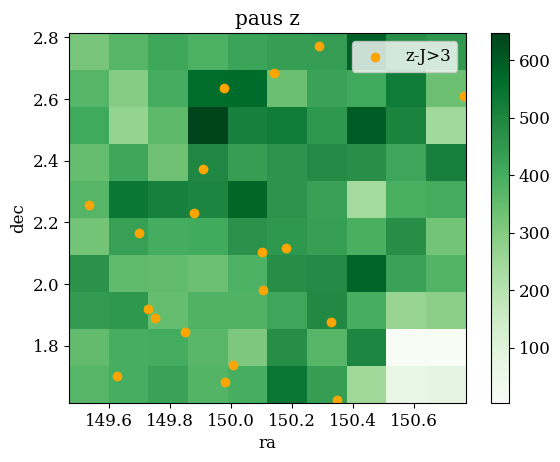

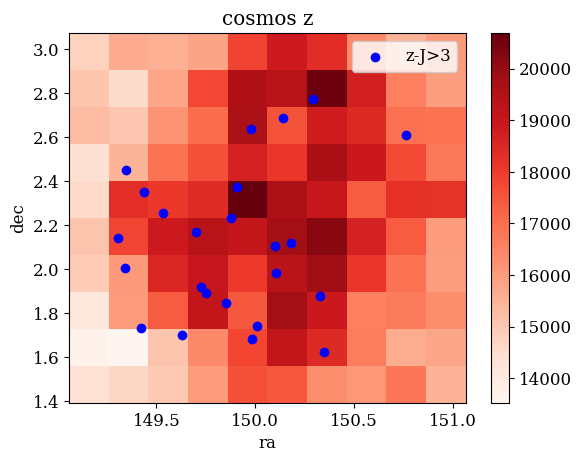

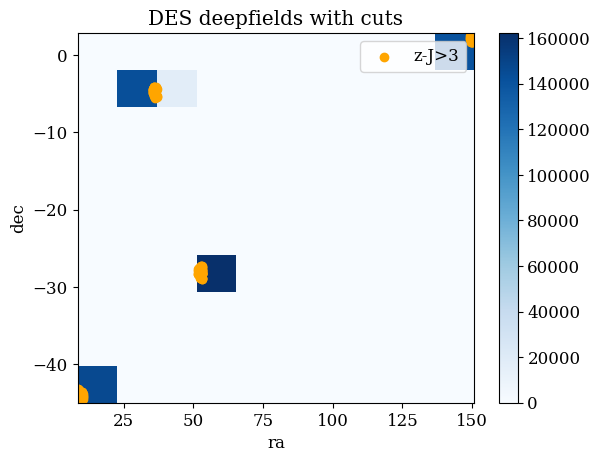

In [36]:
squares = {feat: deep_data[[feat, 'cells']].groupby('cells').agg(['mean', 'median', 'std', len])[feat] for feat in feat_labels}

mean_z_J = squares['z-J']['mean']
mask_z_J_3 = mean_z_J>3
cells_z_J_3 = np.array(range(48**2))[mask_z_J_3.values.flatten()]
deep_data_mask_cells_z_J_3 = np.in1d(deep_data['cells'].values.flatten(), cells_z_J_3)

plt.title('spec z')
plt.hist2d(specz['RA'], specz['DEC'], cmap='Purples');
plt.colorbar()

badz_J_cell_data = deep_data[deep_data_mask_cells_z_J_3]
plt.scatter(badz_J_cell_data['RA'], badz_J_cell_data['DEC'], c='orange', label='z-J>3')
plt.legend()
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

plt.title('paus z')
plt.hist2d(pauscosmos['ra'], pauscosmos['dec'], cmap='Greens');
plt.colorbar()

badz_J_cell_data = deep_data[deep_data_mask_cells_z_J_3]
plt.scatter(badz_J_cell_data['RA'], badz_J_cell_data['DEC'], c='orange', label='z-J>3')
plt.legend()
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

plt.title('cosmos z')
plt.hist2d(cosmos2020['alpha_j2000'], cosmos2020['delta_j2000'], cmap='Reds');
plt.colorbar()

badz_J_cell_data = deep_data[deep_data_mask_cells_z_J_3]
plt.scatter(badz_J_cell_data['RA'], badz_J_cell_data['DEC'], c='blue', label='z-J>3')
plt.legend()
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

plt.title('DES deepfields with cuts')
plt.hist2d(deep_data['RA'], deep_data['DEC'], cmap='Blues');
plt.colorbar()

badz_J_cell_data = deep_data[deep_data_mask_cells_z_J_3]
plt.scatter(badz_J_cell_data['RA'], badz_J_cell_data['DEC'], c='orange', label='z-J>3')
plt.legend()
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

In [40]:
deep_data["lp_type"] = np.nan

spec_cd = SkyCoord(ra=cosmos2020['alpha_j2000'].values*u.degree, dec=cosmos2020['delta_j2000'].values*u.degree)
deep_cd = SkyCoord(ra=deep_data['RA'].values*u.deg, dec=deep_data['DEC'].values*u.deg)
idx, d2d, d3d = deep_cd.match_to_catalog_sky(spec_cd)
good_matches = d2d < 1.0*u.arcsec
# print(len(np.unique(idx[good_matches])), np.count_nonzero(good_matches))

# Add spectra to DELVE catalog
deep_data.loc[good_matches, 'lp_type'] = cosmos2020.iloc[idx[good_matches], cosmos2020.columns.get_loc('lp_type')].values

In [48]:
np.sum(deep_data['lp_type'][(~np.isnan(deep_data['lp_type']))&(deep_data['lp_type'].values!=-9)].values)/9

-1366.0

In [52]:
nonan_lp_types = deep_data['lp_type'][~np.isnan(deep_data['lp_type'])]

In [65]:
nonan_lp_types[nonan_lp_types==2].size

1516

In [66]:
nonan_lp_types[nonan_lp_types==1].size

415

In [67]:
nonan_lp_types[nonan_lp_types==0].size

137849

In [77]:
(nonan_lp_types[~((nonan_lp_types==0)|(nonan_lp_types==1)|(nonan_lp_types==2))]==-99).size

159

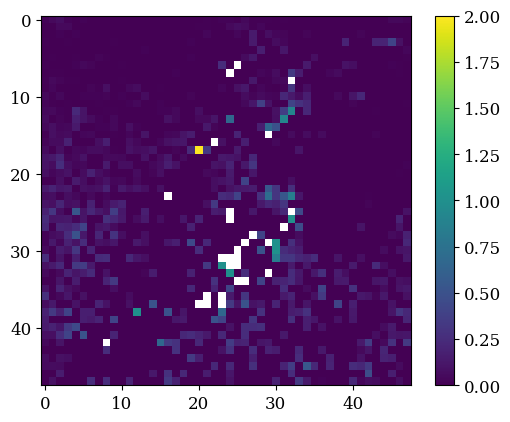

In [119]:
square = deep_data[['lp_type', 'cells']].groupby('cells').agg(['mean', 'median', 'std', len])
im = square[('lp_type', 'mean')].values.reshape(n,n)
plt.imshow(im, cmap='viridis', vmin=0, vmax=2)
plt.colorbar()

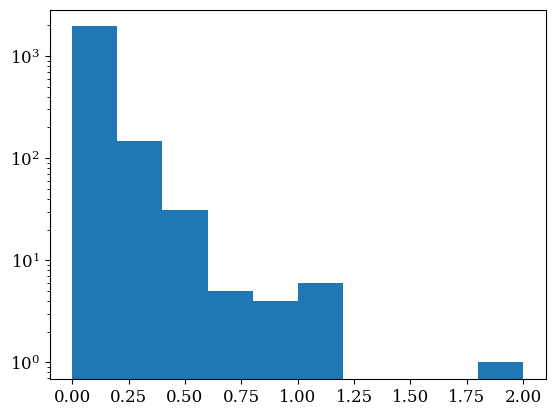

In [123]:
plt.hist(im.flatten()[im.flatten()>=0])
plt.yscale('log')

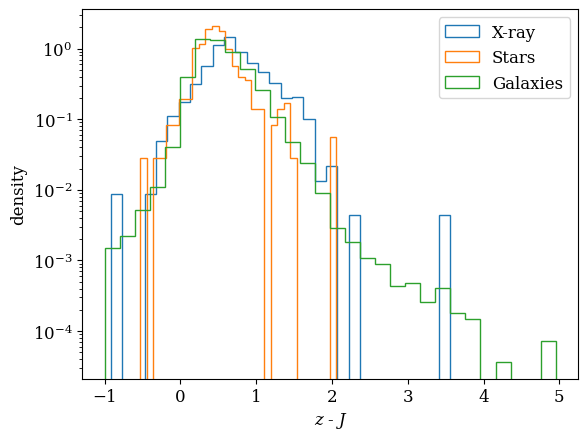

In [134]:
plt.hist(deep_data['z-J'][deep_data['lp_type']==2], bins=30, histtype='step', label='X-ray', density=True)
plt.hist(deep_data['z-J'][deep_data['lp_type']==1], bins=30, histtype='step', label='Stars', density=True)
plt.hist(deep_data['z-J'][deep_data['lp_type']==0], bins=30, histtype='step', label='Galaxies', density=True)
plt.legend()
plt.xlabel('z - J', style='italic')
plt.ylabel('density')
plt.yscale('log')

In [ ]:
ebv = deep_data[(deep_data['RA'].values<78.5)&(50<deep_data['RA'].values)]

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

n_color = 2**10
viridis = cm.get_cmap('viridis', n_color)
Blues_r = cm.get_cmap('Blues_r', n_color)
Oranges = cm.get_cmap('Oranges', n_color)

In [ ]:
# def combine_cmaps(cmap1, cmap2, n_color, w1=1, w2=1):
#     cmapw1 = np.array(w1).reshape(n_color,1)*cmap1(range(n_color))
#     cmapw2 = np.array(w2).reshape(n_color,1)*cmap2(range(n_color))
#     cmap_sum = cmapw1+cmapw2
#     cmap_sum[:,3]=1.
#     cmap_sum[:,0:3]=1/np.sum(cmap_sum[:,0:3], axis=1).reshape(n_color,1) * cmap_sum[:,0:3]
#     cmap_sum[:,3]=0.9
#     result = ListedColormap(cmap_sum)
#     return result

# floor = np.sqrt(np.cos((np.linspace(0, 1, n_color)-.5)))
# plt.plot(np.linspace(0, 1, n_color), floor)
# plt.show()

# for alpha in range(10):
#     w1 = np.exp(-np.linspace(0, 1, n_color))
#     w1 /= np.sum(w1)
#     w1 += 10**-(np.linspace(2.55, 2.66, 10)[alpha])*floor
#     w1 /= np.sum(w1)
#     w2 = np.flip(w1)
#     print(-np.linspace(2, 3, 10)[alpha])
#     plt.plot(np.linspace(0, 1, n_color), w1+w2)
#     plt.show()
# combine_cmaps(Blues_r, Oranges, n_color, w1=w1, w2=w2)

In [101]:
#deep_data.to_csv('/project2/chihway/raulteixeira/data/deep_fields_nice_n_z.csv.gz')